In [1]:
!pip install openpyxl

In [2]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from transformers import AutoTokenizer
import torch
import io
import os
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.metrics import classification_report,accuracy_score
import transformers
import json
from tqdm.notebook import tqdm
from transformers.utils.dummy_pt_objects import AutoModelForSequenceClassification
from transformers import AutoModelForTokenClassification,AutoConfig,AutoModel,AutoTokenizer,BertModel,BertConfig,AdamW, get_constant_schedule,BertForSequenceClassification,get_linear_schedule_with_warmup
import random
import numpy as np
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Mini_Project/data.csv')
df

,date,title,target
0,2022-02-14,το μαξίμου έχει νεύρα με το κιναλ,0
1,2021-02-28,κουφοντίνας δε θέλω να πεθάνω αλλά δεν μου αφή...,0
2,2020-07-04,δέκα σημεία για το δυσοίωνο μεθαύριο της εκπαί...,0
3,2022-02-03,αντιδράσεις για το νέο οργανισμό του υπουργείο...,0
4,2022-08-25,η κλήρωση των ομίλων όλα τα γκρουπ,0
...,...,...,...
3463,2022-12-23,τρεις τραυματίες από προσπάθεια άνδρα να τυλίξ...,1
3464,2022-12-24,δεν υπήρχαν γαλοπούλες την εποχή του χριστού υ...,1
3465,2022-12-24,πιο ευχάριστη η αφαίρεση φρονιμίτη χωρίς αναισ...,1
3466,2022-12-28,σε ξαφνική σύσφιξη μυών του γιάνη βαρουφάκη οφ...,1


In [6]:
df_0 = df[df['target']==0]
df_1 = df[df['target']==1]
print(df_0.shape)
print(df_1.shape)



(1735, 3)
(1733, 3)


In [7]:
df_train_0 = df_0.iloc[:1390,:]
df_train_1 = df_1.iloc[:1390,:]
train = df_train_0.append(df_train_1)
df_test_0 = df_0.iloc[1390:1735,:]
df_test_1 = df_1.iloc[1390:1733,:]
test = df_test_0.append(df_test_1)

train = train.sample(frac=1)
test = test.sample(frac=1)

<ipython-input-7-96ebc1c53e9a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = df_train_0.append(df_train_1)
<ipython-input-7-96ebc1c53e9a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = df_test_0.append(df_test_1)


In [8]:
print(train['target'].value_counts())
print(test['target'].value_counts())
print(train.shape)
print(test.shape)
print(train)
print(test)

0    1390
1    1390
Name: target, dtype: int64
0    345
1    343
Name: target, dtype: int64
(2780, 3)
(688, 3)
            date                                              title  target
835   2021-02-16  μήδεια σε ποιες περιοχές παραμένουν κλειστά τα...       0
724   2020-04-16  μένουμε σπίτι με την ξεκαρδιστική κωμωδία  η κ...       0
2645  2021-08-30  τρεις συγκεντρώσεις αντιεμβολιαστών μας χωρίζο...       1
2276  2021-01-08  απορεί με την ηλιθιότητα των αμερικάνων χρονος...       1
547   2022-07-20  συριζα για κυβέρνηση δίνουν συγχαρητήρια στον ...       0
...          ...                                                ...     ...
2679  2021-09-17  έδιωξε ήδη τον χριστό από τον παράδεισο ο ντού...       1
355   2022-03-14     χωρίς  οι αφίξεις όλων των επιβατών εξωτερικού       0
2672  2021-09-14  δεν φέραμε κορονοϊό στα σχολεία φέραμε την ευλ...       1
1388  2021-01-20                     ο επικίνδυνος κύριος ιερώνυμος       0
3030  2022-03-28  όλο και λιγότεροι έλληνες ονομάζουν

#Tokenization and model loading

In [9]:
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")
model = TFBertForSequenceClassification.from_pretrained("nlpaueb/bert-base-greek-uncased-v1")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Data Conversion

In [10]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN):
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  test_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  return train_InputExamples, test_InputExamples

  train_InputExamples, test_InputExamples = convert_data_to_examples(train,
                                                                           test,
                                                                           'DATA_COLUMN',
                                                                           'LABEL_COLUMN')
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

Training the model: The code compiles the BERT model using the Adam optimizer and sparse categorical cross-entropy loss. It then fits the model on the training data (train_data) for 2 epochs.

In [11]:
DATA_COLUMN = 'title'
LABEL_COLUMN = 'target'

train_InputExamples, test_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(32)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

model_fit=model.fit(train_data, epochs=2)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/2
174/174 [==============================] - 206s 830ms/step - loss: 0.2803
Epoch 2/2
174/174 [==============================] - 141s 812ms/step - loss: 0.0775


In [12]:
model.save_weights('/content/drive/MyDrive/Mini_Project/GR_BERT+ LSTM/ΒΕΡΤ_finetuning/fine-tuned-bert-gr.h5')
model.save_pretrained("/content/drive/MyDrive/Mini_Project/GR_BERT+ LSTM/ΒΕΡΤ_finetuning/")
tokenizer.save_pretrained("/content/drive/MyDrive/Mini_Project/GR_BERT+ LSTM/ΒΕΡΤ_finetuning/")

('/content/drive/MyDrive/Mini_Project/GR_BERT+ LSTM/ΒΕΡΤ_finetuning/tokenizer_config.json',
 '/content/drive/MyDrive/Mini_Project/GR_BERT+ LSTM/ΒΕΡΤ_finetuning/special_tokens_map.json',
 '/content/drive/MyDrive/Mini_Project/GR_BERT+ LSTM/ΒΕΡΤ_finetuning/vocab.txt',
 '/content/drive/MyDrive/Mini_Project/GR_BERT+ LSTM/ΒΕΡΤ_finetuning/added_tokens.json',
 '/content/drive/MyDrive/Mini_Project/GR_BERT+ LSTM/ΒΕΡΤ_finetuning/tokenizer.json')

In [13]:
tp = 0
fp = 0
tn = 0
fn = 0
for title, label in zip(test['title'], test['target']):
  tf_batch = tokenizer(title, max_length=128, padding=True, truncation=True, return_tensors='tf')
  tf_outputs = model(tf_batch)
  tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
  pred_label = tf.argmax(tf_predictions, axis=1)
  if pred_label == 1 and label == 1:
    tp +=1
  elif pred_label == 1 and label == 0:
    fp +=1
  elif pred_label == 0 and label == 0:
    tn +=1
  else:
    fn +=1

accuracy = (tp+tn)/(tp+fp+fn+tn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1score = 2*((recall*precision)/(recall+precision))
print([tp,fn])
print([fp,tn])
print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))
print('F1-score: {:.2f}%'.format(f1score*100))

[316, 27]
[19, 326]
Accuracy: 93.31%
Precision: 94.33%
Recall: 92.13%
F1-score: 93.22%


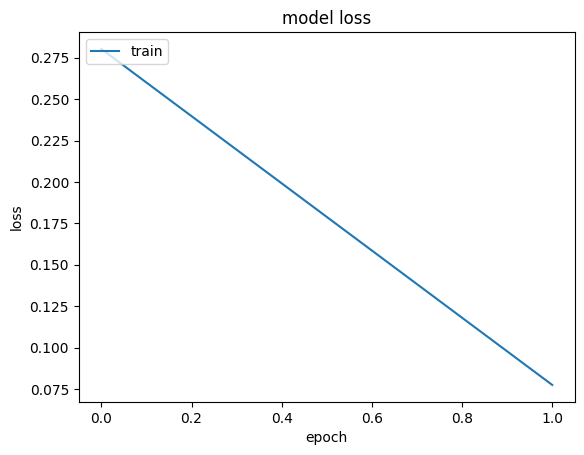

In [14]:
# summarize history for loss
plt.plot(model_fit.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('bert_loss.jpeg')

In [15]:
def check_sarcasm(sentence):
    tf_batch = tokenizer(sentence, max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = model(tf_batch)
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
    pred_label = tf.argmax(tf_predictions, axis=1)

    if pred_label == 1:
        return "Sarcastic"
    else:
        return "Not sarcastic"

# Example usage
sentence = "Κορονοιό έχεις μόνο άν κάνεις τεστ!"
result = check_sarcasm(sentence)
print(result)

Sarcastic


In [16]:
# Initialize an empty list to store the predictions
predictions = []

# Iterate over the test data
for title, label in zip(test['title'], test['target']):
  tf_batch = tokenizer(title, max_length=128, padding=True, truncation=True, return_tensors='tf')
  tf_outputs = model(tf_batch)
  tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
  pred_label = tf.argmax(tf_predictions, axis=1)

  # Append the prediction to the list
  predictions.append(pred_label.numpy()[0])

# Add the predictions as a new column in the DataFrame
test['predictions'] = predictions

# Print the updated DataFrame
print(test)

            date                                              title  target  \
1556  2020-11-06  δολοφονία φλόιντ ελεύθερος με εγγύηση ένας από...       0   
3340  2022-10-18  πέθανε ο τελευταίος κάτοχος μηχανακιού της  στ...       1   
1666  2021-11-11      αλματώδης η αύξηση των κρουσμάτων στην κοζάνη       0   
1636  2021-04-21                   το παρασκήνιο του πραξικοπήματος       0   
1464  2021-05-26  ψήφος απόδημων κάτω από τον πήχυ  ψήφων νομοσσ...       0   
...          ...                                                ...     ...   
3404  2022-11-21  σε απόγνωση ραδιοφωνικός  που δεν πρόλαβε να π...       1   
1569  2022-12-08                         σεισμός  ρίχτερ στην κρήτη       0   
3298  2022-09-21  σκόπιμη η επιστροφή της βίκυς καγιά στο  για ν...       1   
1503  2021-06-23  προοδευτική διακυβέρνηση προϋποθέσεις και αντι...       0   
3259  2022-09-02  με οξεία υπερκόπωση διαγνώστηκε ο κώστας καραμ...       1   

      predictions  
1556            0  
3340       

In [17]:
test

,date,title,target,predictions
1556,2020-11-06,δολοφονία φλόιντ ελεύθερος με εγγύηση ένας από...,0,0
3340,2022-10-18,πέθανε ο τελευταίος κάτοχος μηχανακιού της στ...,1,1
1666,2021-11-11,αλματώδης η αύξηση των κρουσμάτων στην κοζάνη,0,0
1636,2021-04-21,το παρασκήνιο του πραξικοπήματος,0,0
1464,2021-05-26,ψήφος απόδημων κάτω από τον πήχυ ψήφων νομοσσ...,0,0
...,...,...,...,...
3404,2022-11-21,σε απόγνωση ραδιοφωνικός που δεν πρόλαβε να π...,1,1
1569,2022-12-08,σεισμός ρίχτερ στην κρήτη,0,0
3298,2022-09-21,σκόπιμη η επιστροφή της βίκυς καγιά στο για ν...,1,1
1503,2021-06-23,προοδευτική διακυβέρνηση προϋποθέσεις και αντι...,0,0
